In [44]:
# Estos dos comandos evitan que haya que hacer reload cada vez que se modifica un paquete
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter

In [46]:
examples = -1

In [47]:
data = pd.read_csv('data/alturas-pesos-mils-train.csv')[:examples]
data_cv = pd.read_csv('data/alturas-pesos-mils-test.csv')[:examples]

In [48]:
from sklearn.preprocessing import MinMaxScaler
normalizeData = MinMaxScaler()
X_train  = normalizeData.fit_transform(data[['Peso', 'Altura']].values)
X_cv  = normalizeData.transform(data_cv[['Peso', 'Altura']].values)

In [49]:
data_hombres = normalizeData.transform(data.loc[data['Genero']=='Hombre'][['Peso','Altura']].values)
data_mujeres = normalizeData.transform(data.loc[data['Genero']=='Mujer'][['Peso','Altura']].values)

In [50]:
labels = data['Genero'].values.copy()
labels[labels=='Hombre'] = 0
labels[labels=='Mujer'] = 1

In [51]:
labels_cv = data_cv['Genero'].values.copy()
labels_cv[labels_cv=='Hombre'] = 0
labels_cv[labels_cv=='Mujer'] = 1

In [52]:
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam, SGD

In [29]:
from polynomial_helper import get_polynimial_set, PlotBoundary

# Regresión logística polinomial con Keras

In [53]:
degree=1
X_train_pol = get_polynimial_set(X_train, degree=degree, bias=False)
X_cv_pol = get_polynimial_set(X_cv, degree=degree, bias=False)

In [54]:
model = Sequential()
model.add(Dense(1, input_dim=X_train_pol.shape[1], activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Lineal: Adam lr=5 se ve inercia (len_data=500)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=5), metrics=['accuracy'])
# Lineal: SGD lr=5 se ve que no tiene inercia y 
# le cuesta mucho converger a la solución de la regresión logistica
# Termina en Naive Bayes
# Grado 10: Adam lr=1, luego de 5000 epochs oscila (len_data=50), se baja a lr=0.1 converge
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1), metrics=['accuracy'])
# Grado 10: Adam lr=1, luego de 5000 epochs oscila (len_data=8000), Regularización por conseguir mas datos
#model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1), metrics=['accuracy'])

In [56]:
batch_size = int(len(X_train_pol)/1)

In [57]:
X_cv_pol.shape, labels_cv.shape

((1999, 2), (1999,))

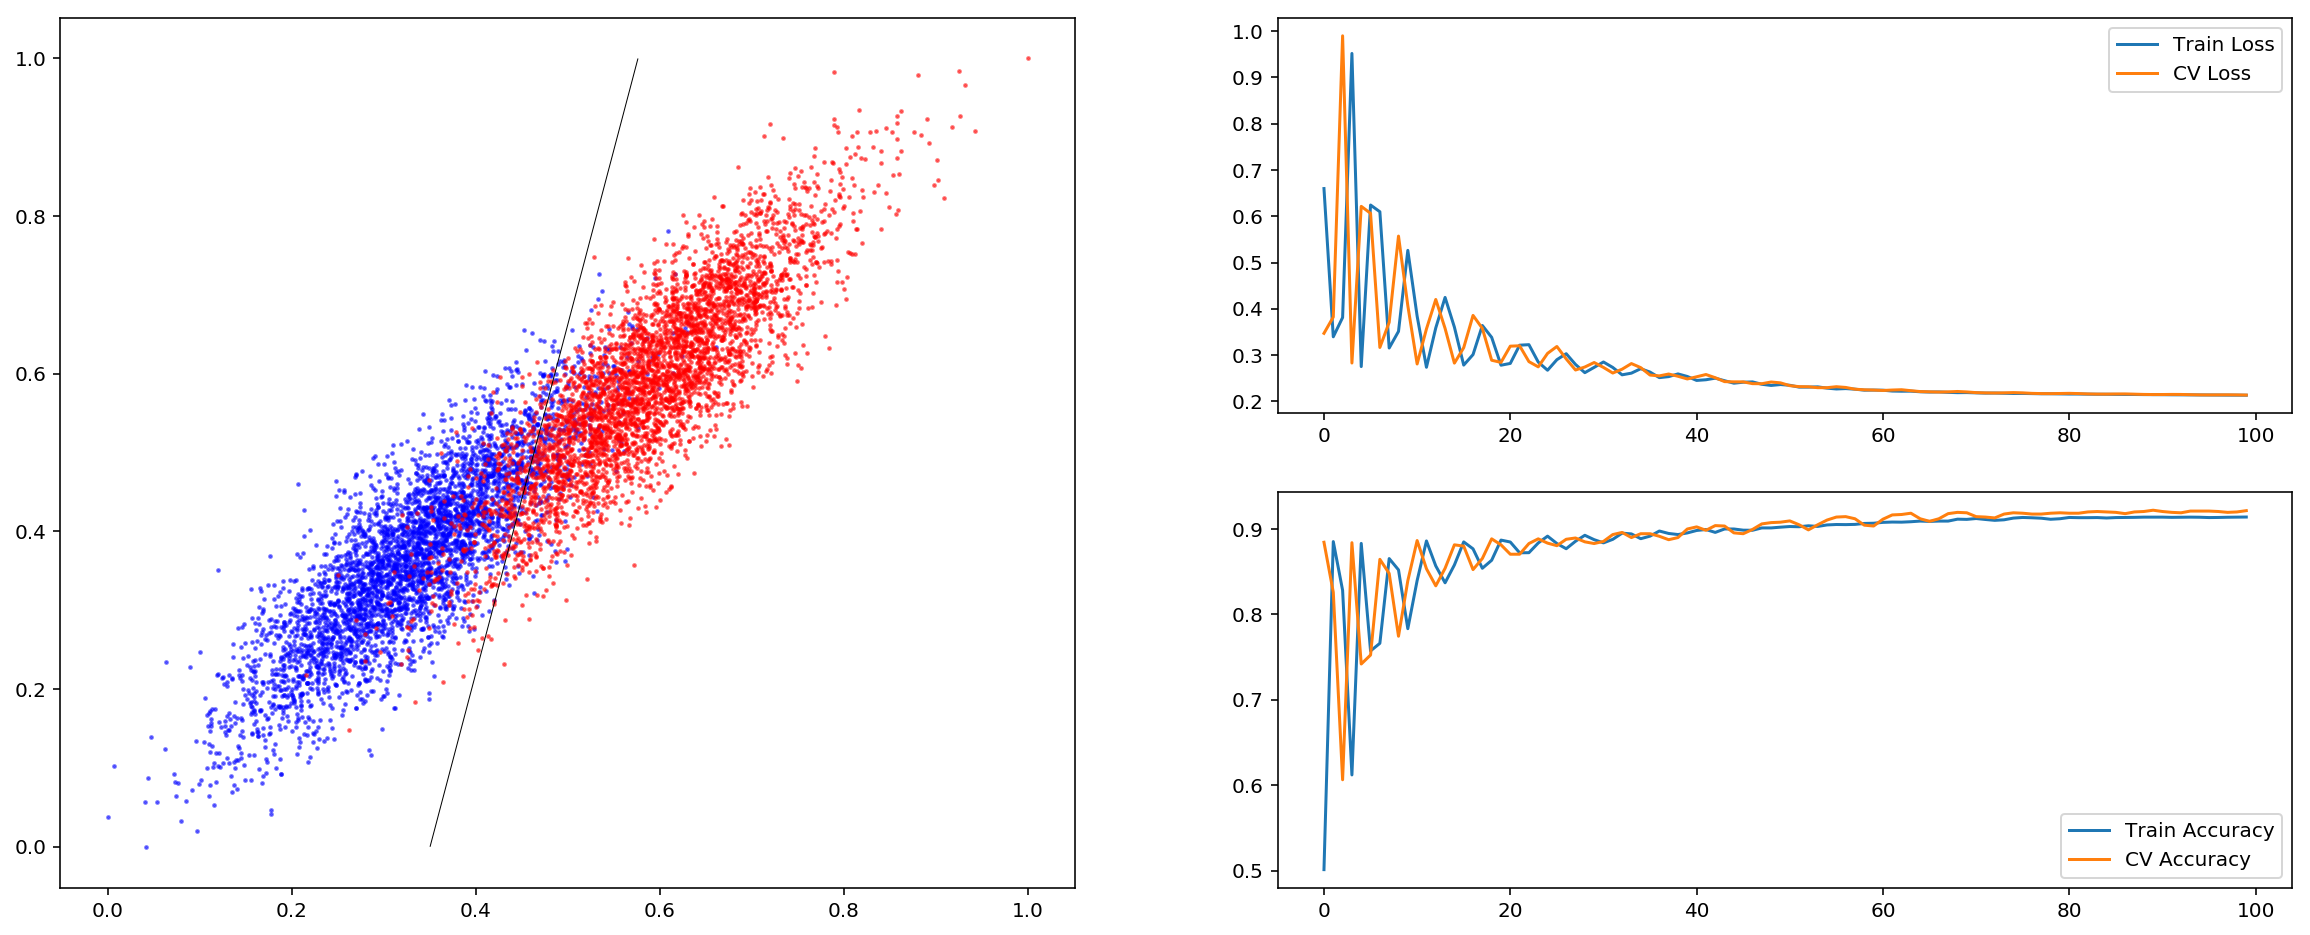

In [58]:
plot_boundary = PlotBoundary(X_train_pol, labels, degree, N=100, plots_every_batches=int(len(X_train_pol)/batch_size))
model_res = model.fit(X_train_pol, labels, epochs=100, batch_size=batch_size, 
                    validation_data = (X_cv_pol, labels_cv),
                      verbose=0, callbacks=[plot_boundary])

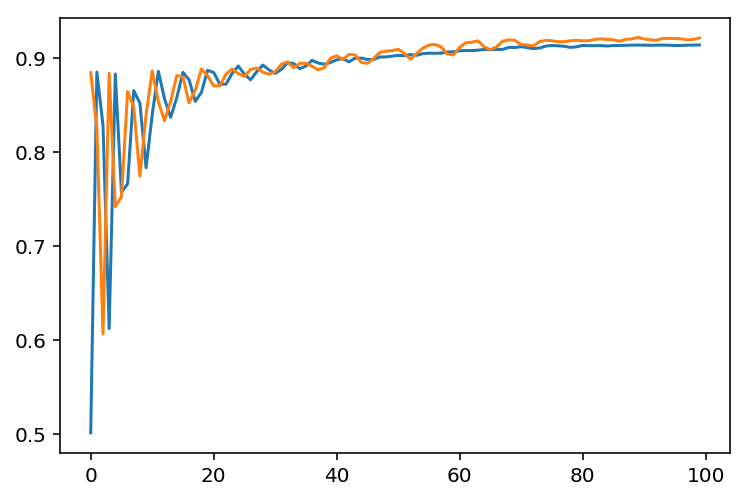

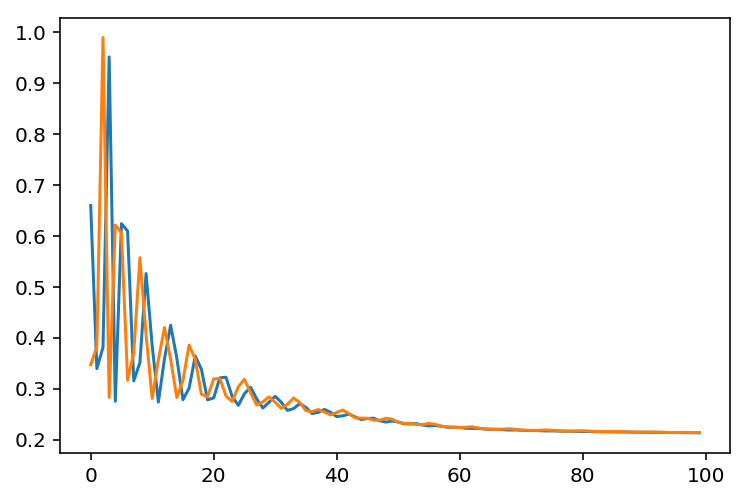

In [67]:
plt.plot(model_res.history['acc'])
plt.plot(model_res.history['val_acc'])
plt.show()
plt.plot(model_res.history['loss'])
plt.plot(model_res.history['val_loss'])
plt.show()

# Regresion logística

In [61]:
from sklearn.linear_model import LogisticRegression
log_Reg = LogisticRegression(C=1000)
log_Reg.fit(X_train, data['Genero'])

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [62]:
log_Reg.score(X_train, data['Genero'])

0.9164895611951493

In [63]:
# Red neuronal
model.evaluate(get_polynimial_set(X_train, degree), labels)

7999/7999 [==============================] - 0s 36us/step


[0.21318878824523962, 0.9134891860439474]

In [60]:
mins = X_train.min(axis=0)
maxs = X_train.max(axis=0)

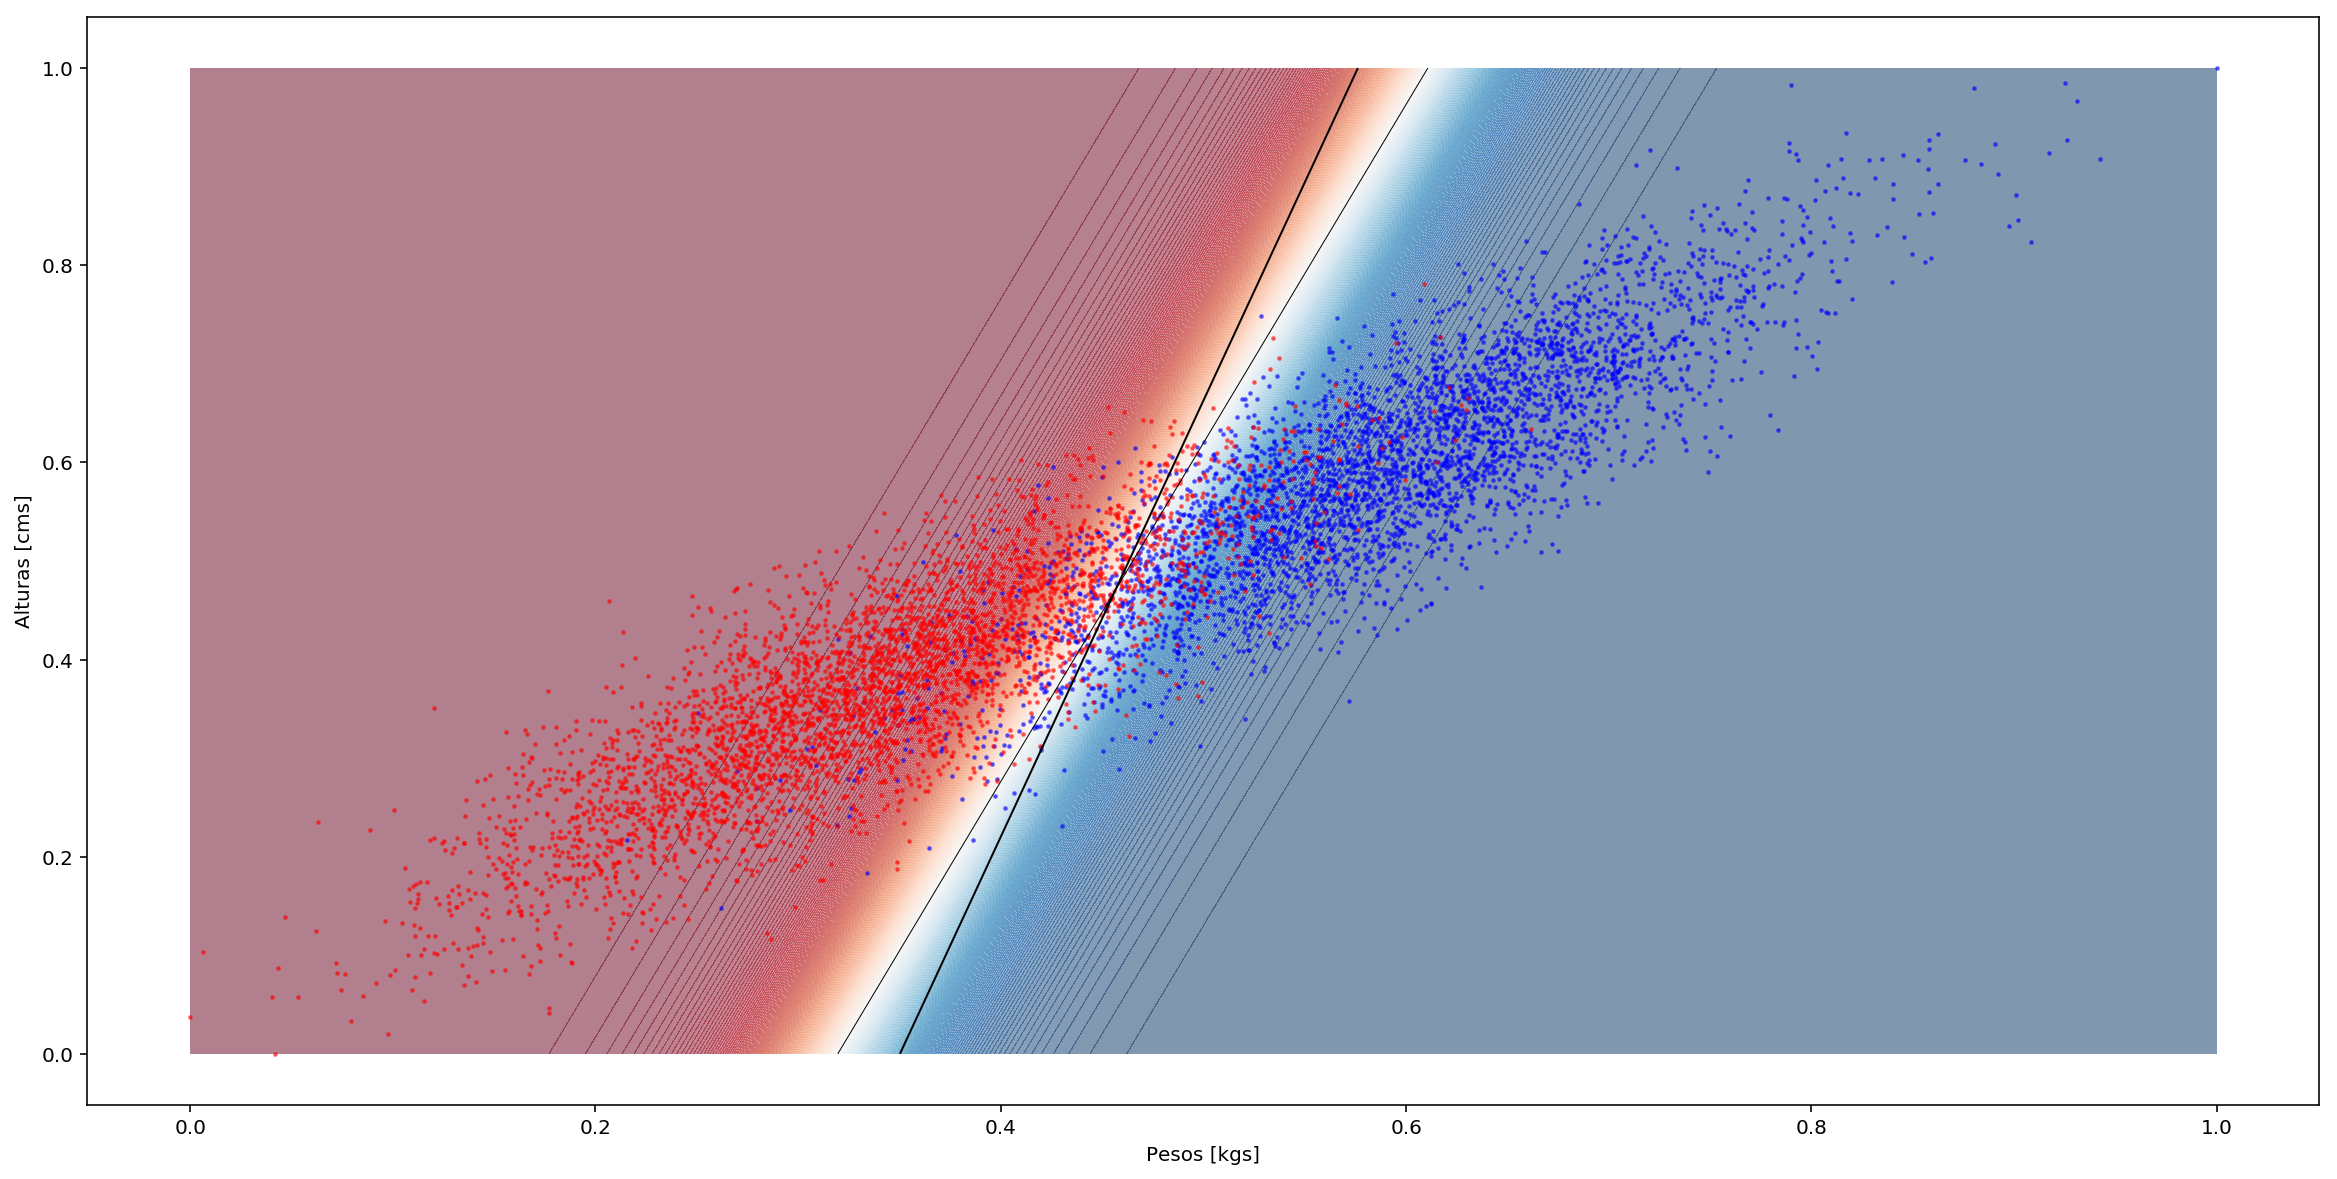

In [64]:
%matplotlib inline
N = 300
X = np.linspace(mins[0], maxs[0], N)
Y = np.linspace(mins[1], maxs[1], N)
X, Y = np.meshgrid(X, Y)

Z_nn = model.predict_proba(get_polynimial_set(np.c_[X.flatten(), Y.flatten()], degree))[:, 0]
Z_lr = log_Reg.predict_proba(np.c_[X.flatten(), Y.flatten()])[:, 0]

# Put the result into a color plot
Z_lr = Z_lr.reshape(X.shape)
Z_nn = Z_nn.reshape(X.shape)

fig = plt.figure(figsize=(20,10))
ax = fig.gca()
cm = plt.cm.RdBu
cf = ax.contourf(X, Y, Z_lr, 256, alpha=.5, vmin=0., vmax=1., cmap=cm)
ax.contour(X, Y, Z_lr, (0.5,), colors='k', linewidths=0.5)
ax.contour(X, Y, Z_nn, (0.5,), colors='k', linewidths=1)
ax.scatter(data_hombres[:,0], data_hombres[:,1], color='b', s=2, alpha=0.5)
ax.scatter(data_mujeres[:,0], data_mujeres[:,1], color='r', s=2, alpha=0.5)
ax.set_ylabel('Alturas [cms]')
ax.set_xlabel('Pesos [kgs]')
#plt.colorbar(cf, ax=ax)
plt.show()